c:\Users\Vedant\miniconda3\envs\qiskit-ok\lib\site-packages\qutip\solver\solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


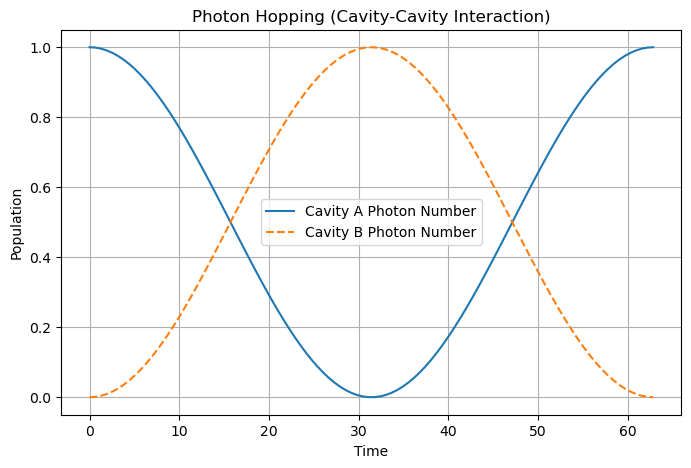

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

def build_coupled_cavities(N, w_a, w_b, g_hop):
    # 1. Define Operators
    # a acts on Cavity A (1st slot), b acts on Cavity B (2nd slot)
    a = tensor(destroy(N), qeye(N))
    b = tensor(qeye(N), destroy(N))
    
    # 2. Hamiltonian (from your notebook)
    # H = wa*a^dag*a + wb*b^dag*b + g(a^dag*b + a*b^dag)
    H_a = w_a * a.dag() * a
    H_b = w_b * b.dag() * b
    H_hop = g_hop * (a.dag() * b + a * b.dag())
    
    return H_a + H_b + H_hop

# --- Parameters ---
N = 10              # Hilbert space size
w_0 = 1.0           # Frequency
g_hop = 0.05        # Hopping strength (The 'g' in your notebook)

H = build_coupled_cavities(N, w_0, w_0, g_hop)

# --- Initial State ---
# One photon in Cavity A, Vacuum in Cavity B
# |1> (x) |0>
psi0 = tensor(basis(N, 1), basis(N, 0))

# --- Time Evolution ---
# We want to see the photon swap completely. 
# Period T = pi / g_hop
t_max = np.pi / g_hop
tlist = np.linspace(0, t_max, 100)

# Track photon numbers in A and B
n_a = tensor(num(N), qeye(N))
n_b = tensor(qeye(N), num(N))

output = mesolve(H, psi0, tlist, [], [n_a, n_b])

# --- Plotting 1: Photon Numbers ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tlist, output.expect[0], label="Cavity A Photon Number")
ax.plot(tlist, output.expect[1], label="Cavity B Photon Number", linestyle="--")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("Photon Hopping (Cavity-Cavity Interaction)")
ax.legend()
ax.grid(True)
plt.show()

c:\Users\Vedant\miniconda3\envs\qiskit-ok\lib\site-packages\qutip\solver\solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


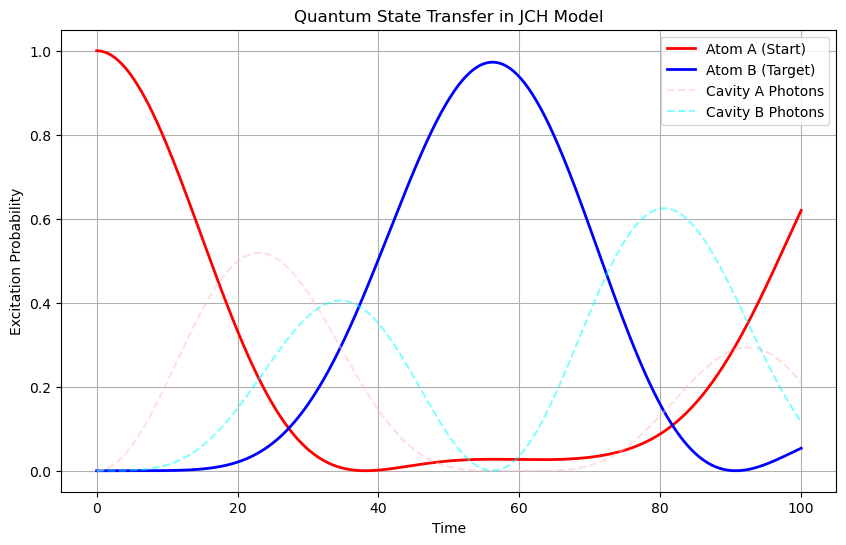

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

def build_jch_2site(N, w_c, w_a, g, J):
    """
    Constructs the 2-site Jaynes-Cummings-Hubbard Hamiltonian.
    Order: Cavity A, Atom A, Cavity B, Atom B
    """
    
    # 1. Define Basic Operators 
    # System A Operators
    a1  = tensor(destroy(N), qeye(2), qeye(N), qeye(2))
    sm1 = tensor(qeye(N), sigmam(), qeye(N), qeye(2))
    sz1 = tensor(qeye(N), sigmaz(), qeye(N), qeye(2))
    
    # System B Operators
    a2  = tensor(qeye(N), qeye(2), destroy(N), qeye(2))
    sm2 = tensor(qeye(N), qeye(2), qeye(N), sigmam())
    sz2 = tensor(qeye(N), qeye(2), qeye(N), sigmaz())
    
    # 2. Build Hamiltonian
    H_A = w_c * a1.dag() * a1 + \
          0.5 * w_a * sz1 + \
          g * (a1.dag() * sm1 + a1 * sm1.dag())
          
    # Local JC Dynamics (System B)
    H_B = w_c * a2.dag() * a2 + \
          0.5 * w_a * sz2 + \
          g * (a2.dag() * sm2 + a2 * sm2.dag())
          

    H_hop = -J * (a1.dag() * a2 + a1 * a2.dag())
    
    H_total = H_A + H_B + H_hop
    
    return H_total, a1, a2, sz1, sz2

# Physics Parameters
N = 3               # Keep small (Total size = 64 states)
w = 1.0             # Resonance
g = 0.05            # Atom-Cavity Coupling
J = 0.05            # Hopping Strength

# Build System
H, a1, a2, sz1, sz2 = build_jch_2site(N, w, w, g, J)

# Initial State: Atom A excited, Atom B ground

psi0 = tensor(basis(N,0), basis(2,0), basis(N,0), basis(2,1))

# Time List

tlist = np.linspace(0, 100, 500)

# Observables
P_exc_A = (sz1 + 1)/2
P_exc_B = (sz2 + 1)/2

output = mesolve(H, psi0, tlist, [], [P_exc_A, P_exc_B, a1.dag()*a1, a2.dag()*a2])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(tlist, output.expect[0], label="Atom A (Start)", color="r", linewidth=2)
ax.plot(tlist, output.expect[1], label="Atom B (Target)", color="b", linewidth=2)
ax.plot(tlist, output.expect[2], label="Cavity A Photons", color="pink", linestyle="--", alpha=0.5)
ax.plot(tlist, output.expect[3], label="Cavity B Photons", color="cyan", linestyle="--", alpha=0.5)

ax.set_xlabel("Time")
ax.set_ylabel("Excitation Probability")
ax.set_title("Quantum State Transfer in JCH Model")
ax.legend()
ax.grid(True)

plt.show()

In [2]:
# TIMING THE SIMULATION 
print("Starting QuTiP simulation...")


time = %timeit -o mesolve(H, psi0, tlist, [], [P_exc_A, P_exc_B])

print(f"QuTiP Execution Time: {time.average:.5f} seconds")

Starting QuTiP simulation...
16.9 ms ± 948 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
QuTiP Execution Time: 0.01689 seconds


In [3]:
import numpy as np
import time
from qutip import *

def run_python_benchmark(N_values):
    times = []
    w, g, J = 1.0, 0.05, 0.05
    tlist = np.linspace(0, 50, 200) # Fair Resolution
    
    print("--- Python (QuTiP) Benchmark ---")
    for N in N_values:
        # Build System
        a1  = tensor(destroy(N), qeye(2), qeye(N), qeye(2))
        sm1 = tensor(qeye(N), sigmam(), qeye(N), qeye(2))
        sz1 = tensor(qeye(N), sigmaz(), qeye(N), qeye(2))
        a2  = tensor(qeye(N), qeye(2), destroy(N), qeye(2))
        sm2 = tensor(qeye(N), qeye(2), qeye(N), sigmam())
        sz2 = tensor(qeye(N), qeye(2), qeye(N), sigmaz())
        
        H = w*a1.dag()*a1 + 0.5*w*sz1 + g*(a1.dag()*sm1 + a1*sm1.dag()) + \
            w*a2.dag()*a2 + 0.5*w*sz2 + g*(a2.dag()*sm2 + a2*sm2.dag()) - \
            J*(a1.dag()*a2 + a1*a2.dag())
            
        psi0 = tensor(basis(N,0), basis(2,0), basis(N,0), basis(2,1))
        
        # Time the Solver Only
        start = time.time()
        mesolve(H, psi0, tlist, [], []) 
        dt = time.time() - start
        
        times.append(round(dt, 7))
        print(f"N={N}: {dt:.4f} s")
    return times



--- Python (QuTiP) Benchmark ---
N=3: 0.0115 s
N=5: 0.0066 s
N=8: 0.0140 s
N=10: 0.0105 s
N=12: 0.0169 s
N=15: 0.0194 s
N=18: 0.0205 s
N=20: 0.0328 s
Python Times: [0.0114703, 0.0066128, 0.0139878, 0.0105426, 0.0169332, 0.0193543, 0.0205059, 0.0328486]


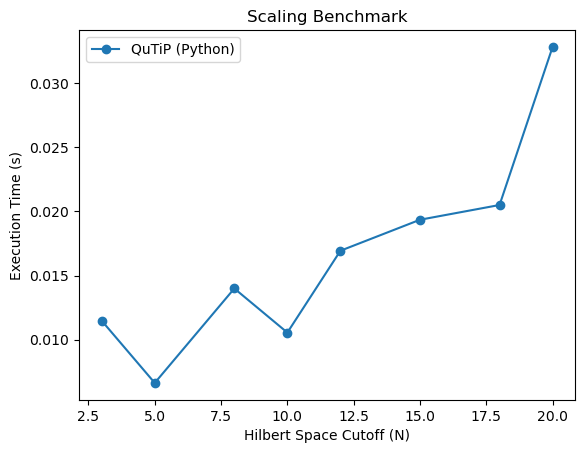

In [ ]:
N_list = [3, 5, 8, 10, 12, 15, 18, 20]
python_times = run_python_benchmark(N_list)
print("Python Times:", python_times)

plt.plot(N_list, python_times, 'o-', label="QuTiP (Python)")
plt.xlabel("Hilbert Space Cutoff (N)")
plt.ylabel("Execution Time (s)")
plt.title("Scaling Benchmark")
plt.legend()
plt.show()
